In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader
#from torch.autograd import grad
import cf_matrix
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
##### LOAD #########
# choose load file name 
train_path="/home/bhagya/Cross_corpora_data_Bhagya/"
test_path="/home/bhagya/Cross_corpora_data_Bhagya/"

f1 = train_path+'X_Original_LDC_train_cms.npy'
f2 = train_path+'y_Original_LDC_train_cms.npy'
#f3 = train_path+'X_train_LDC_kaldi_aug_mfcc_cms.npy'
#f4 = train_path+'y_train_LDC_kaldi_aug_mfcc_cms.npy'
f5 = test_path+'X_Original_LDC_test_cms.npy'
f6 = test_path+'y_Original_LDC_test_cms.npy'

X_train = np.load(f1,allow_pickle=True)
#X_aug=np.load(f3,allow_pickle=True)
X_valid = np.load(f5,allow_pickle=True)
y_train = np.load(f2,allow_pickle=True)
#y_aug=np.load(f4,allow_pickle=True)
y_valid = np.load(f6,allow_pickle=True)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
#print(f'X_aug:{X_aug.shape}, y_aug:{y_aug.shape}') 
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')

X_train:(48261, 300, 20), y_train:(48261,)
X_valid:(7528, 300, 20), y_valid:(7528,)


In [3]:
print(np.unique(y_train,return_counts=True))
#print(np.unique(y_aug,return_counts=True))
print(np.unique(y_valid,return_counts=True))

(array([0, 1, 2, 3, 4], dtype=object), array([ 9882,  2890, 16493, 10146,  8850]))
(array([0, 1, 2, 3, 4], dtype=object), array([1580,  696, 2560, 1343, 1349]))


In [4]:
#not doing where separate source domains are needed as X_aug such as wgdrl
# X_train=np.concatenate((X_train,X_aug))
# del X_aug
# y_train=np.concatenate((y_train,y_aug))
# del y_aug

In [5]:
print(X_train.shape)
print(np.unique(y_train,return_counts=True))

(48261, 300, 20)
(array([0, 1, 2, 3, 4], dtype=object), array([ 9882,  2890, 16493, 10146,  8850]))


In [6]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channesl, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector
    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [7]:
def imbalance_class_weight(y,tot_class):
    classes=np.unique(y,return_counts=True)
    total_samples=np.sum(np.array(classes[1]))
    class_weights=np.empty(tot_class)
    for i,j in enumerate(classes[1]):
        print(i,'--->',j)
        class_weights[i]=total_samples/(tot_class*j)
    print(class_weights)
    return class_weights

In [9]:
class_weights_train=imbalance_class_weight(y_train,5)
class_weights_train2=class_weights_train/np.max(class_weights_train)
print(class_weights_train2)

0 ---> 9882
1 ---> 2890
2 ---> 16493
3 ---> 10146
4 ---> 8850
[0.9767456  3.33986159 0.5852301  0.95133057 1.09064407]
[0.29245092 1.         0.17522585 0.28484132 0.32655367]


In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#deice=torch.device("cpu")
model = ECAPA_TDNN(20, 5).to(device)
class_weights_train = torch.FloatTensor(class_weights_train2).to(device)
loss_fun = nn.CrossEntropyLoss(weight=class_weights_train)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.0000001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [11]:
def xv_data_manage(X_test):
     aa=X_test.transpose((0,2,1))
     print(X_test.shape, '-->', aa.shape)
     return aa

In [12]:
 X_train=xv_data_manage(X_train)
 X_valid=xv_data_manage(X_valid)

(48261, 300, 20) --> (48261, 20, 300)
(7528, 300, 20) --> (7528, 20, 300)


In [13]:
trainloader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=300,drop_last=False)
testloader1 = torch.utils.data.DataLoader(list(zip(X_valid,y_valid)), shuffle=False, batch_size=32,drop_last=False)
#testloader2 = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=32,drop_last=False)
print(len(trainloader))
print(len(testloader1))
#print(len(testloader2))
#print(len(testloader3))

161
236


Epoch: 0, Batch: 0, Loss: 8.62426471710205, Accuracy:21.0%
Epoch: 0, Batch: 50, Loss: 5.0174736976623535, Accuracy:65.0%
Epoch: 0, Batch: 100, Loss: 4.251723766326904, Accuracy:68.0%
Epoch: 0, Batch: 150, Loss: 3.797572135925293, Accuracy:72.66666666666667%
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 7.618607997894287, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 0, Batch: 50, Loss: 4.459034442901611, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 0, Batch: 100, Loss: 11.218109130859375, Accuracy:3.125%
#####TEST--in-domain:::::Epoch: 0, Batch: 150, Loss: 3.202085018157959, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 0, Batch: 200, Loss: 0.7266446948051453, Accuracy:84.375%


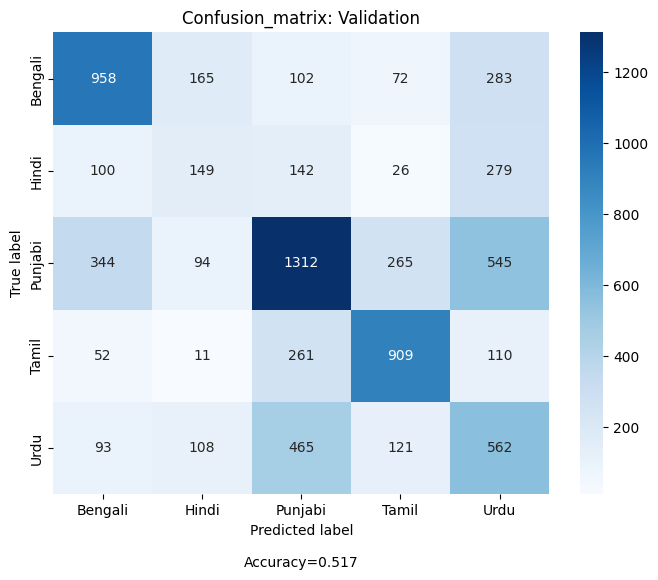

:::::Total vlidation loss 3.02106650833242, Training accuracy 0.6554982283831665, Validation accuracy 0.5167375132837407 after 0 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 1, Batch: 0, Loss: 3.8925676345825195, Accuracy:73.0%
Epoch: 1, Batch: 50, Loss: 3.0122318267822266, Accuracy:80.66666666666666%
Epoch: 1, Batch: 100, Loss: 2.761162281036377, Accuracy:81.66666666666667%
Epoch: 1, Batch: 150, Loss: 2.617936372756958, Accuracy:83.66666666666667%
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 7.74204683303833, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 1, Batch: 50, Loss: 6.205733776092529, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 1, Batch: 100, Loss: 11.840611457824707, Accuracy:3.125%
#####TEST--in-domain:::::Epoch: 1, Batch: 150, Loss: 4.693220615386963, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 1, Batch: 200, Loss: 1.212280035018921, Accuracy:75.0%


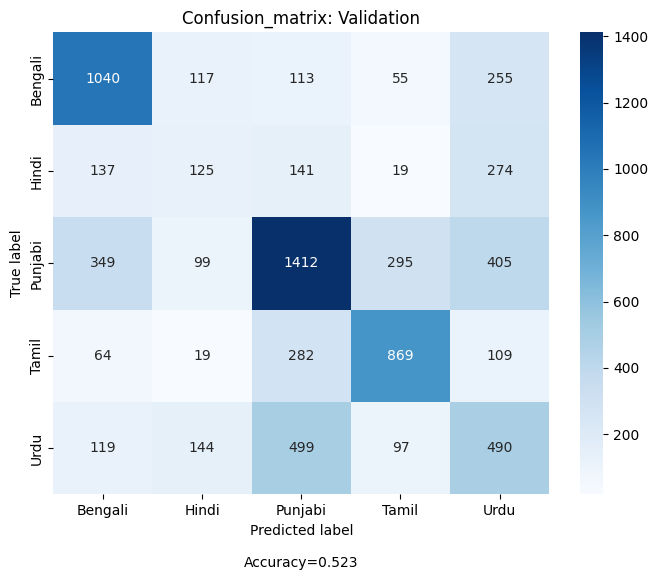

:::::Total vlidation loss 3.552857166565222, Training accuracy 0.8105302418101573, Validation accuracy 0.5228480340063762 after 1 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 2, Batch: 0, Loss: 2.655841588973999, Accuracy:83.33333333333334%
Epoch: 2, Batch: 50, Loss: 2.2967944145202637, Accuracy:84.33333333333334%
Epoch: 2, Batch: 100, Loss: 2.2648730278015137, Accuracy:86.0%
Epoch: 2, Batch: 150, Loss: 2.0530595779418945, Accuracy:86.0%
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 6.761066436767578, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 2, Batch: 50, Loss: 3.9542667865753174, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 2, Batch: 100, Loss: 11.72697639465332, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 2, Batch: 150, Loss: 1.9709646701812744, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 2, Batch: 200, Loss: 2.078219413757324, Accuracy:43.75%


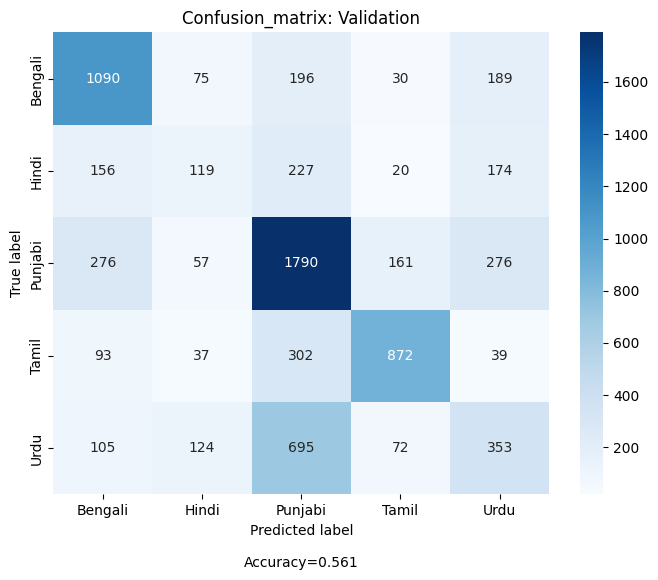

:::::Total vlidation loss 3.458828360163807, Training accuracy 0.8646526180559873, Validation accuracy 0.5611052072263549 after 2 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 3, Batch: 0, Loss: 1.6519954204559326, Accuracy:90.66666666666666%
Epoch: 3, Batch: 50, Loss: 1.568639874458313, Accuracy:92.0%
Epoch: 3, Batch: 100, Loss: 1.6631746292114258, Accuracy:90.0%
Epoch: 3, Batch: 150, Loss: 1.612706184387207, Accuracy:88.66666666666667%
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 10.43964958190918, Accuracy:3.125%
#####TEST--in-domain:::::Epoch: 3, Batch: 50, Loss: 6.1135334968566895, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 3, Batch: 100, Loss: 10.504537582397461, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 3, Batch: 150, Loss: 3.542837619781494, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 3, Batch: 200, Loss: 3.0169148445129395, Accuracy:46.875%


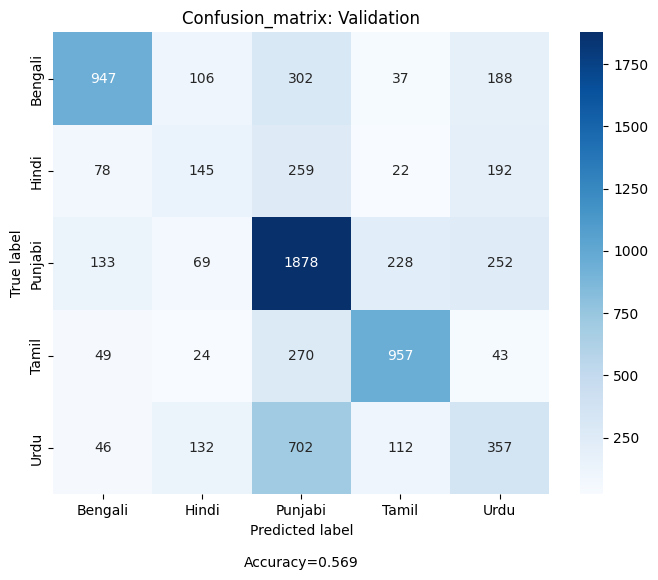

:::::Total vlidation loss 3.6989180885666397, Training accuracy 0.8977227989473903, Validation accuracy 0.5690754516471839 after 3 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 4, Batch: 0, Loss: 1.0517940521240234, Accuracy:93.33333333333333%
Epoch: 4, Batch: 50, Loss: 1.2673710584640503, Accuracy:91.66666666666666%
Epoch: 4, Batch: 100, Loss: 1.1786566972732544, Accuracy:93.66666666666667%
Epoch: 4, Batch: 150, Loss: 1.5102535486221313, Accuracy:89.33333333333333%
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 7.018489360809326, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 4, Batch: 50, Loss: 6.543221473693848, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 4, Batch: 100, Loss: 13.579304695129395, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 4, Batch: 150, Loss: 2.899989366531372, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 4, Batch: 200, Loss: 1.081849455833435, Accuracy:78.125%


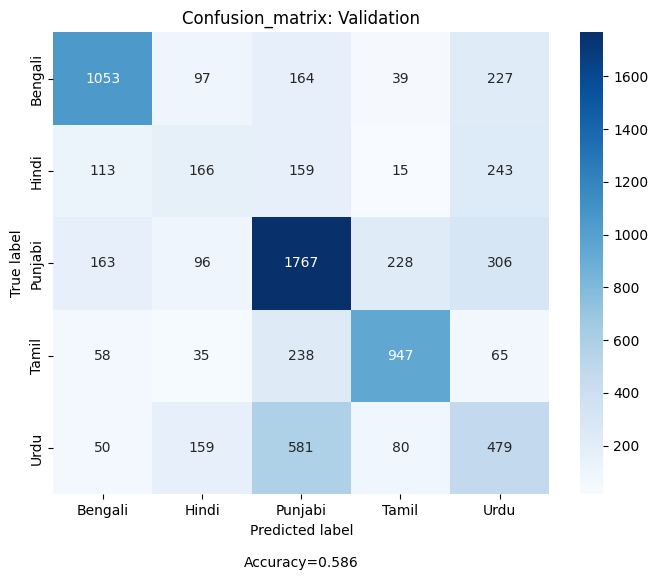

:::::Total vlidation loss 3.7056144969568354, Training accuracy 0.9222975073040343, Validation accuracy 0.5860786397449522 after 4 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 5, Batch: 0, Loss: 1.1623609066009521, Accuracy:92.0%
Epoch: 5, Batch: 50, Loss: 0.8614801168441772, Accuracy:95.66666666666667%
Epoch: 5, Batch: 100, Loss: 0.6972247362136841, Accuracy:96.33333333333334%
Epoch: 5, Batch: 150, Loss: 0.9799625873565674, Accuracy:94.0%
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 5.025115013122559, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 5, Batch: 50, Loss: 7.218436241149902, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 5, Batch: 100, Loss: 13.664033889770508, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 5, Batch: 150, Loss: 2.653310537338257, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 5, Batch: 200, Loss: 2.7691617012023926, Accuracy:56.25%


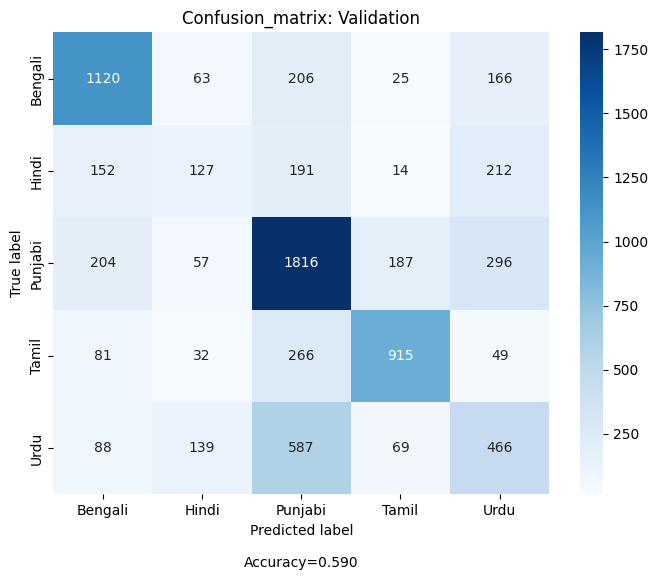

:::::Total vlidation loss 3.9222547558301697, Training accuracy 0.951907337187377, Validation accuracy 0.5903294367693943 after 5 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 6, Batch: 0, Loss: 0.8945125341415405, Accuracy:95.66666666666667%
Epoch: 6, Batch: 50, Loss: 0.5437366962432861, Accuracy:97.66666666666667%
Epoch: 6, Batch: 100, Loss: 0.8498502969741821, Accuracy:94.66666666666667%
Epoch: 6, Batch: 150, Loss: 0.838064968585968, Accuracy:95.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 6.101761341094971, Accuracy:34.375%
#####TEST--in-domain:::::Epoch: 6, Batch: 50, Loss: 5.939670085906982, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 6, Batch: 100, Loss: 14.447267532348633, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 6, Batch: 150, Loss: 2.5798275470733643, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 6, Batch: 200, Loss: 3.5306735038757324, Accuracy:46.875%


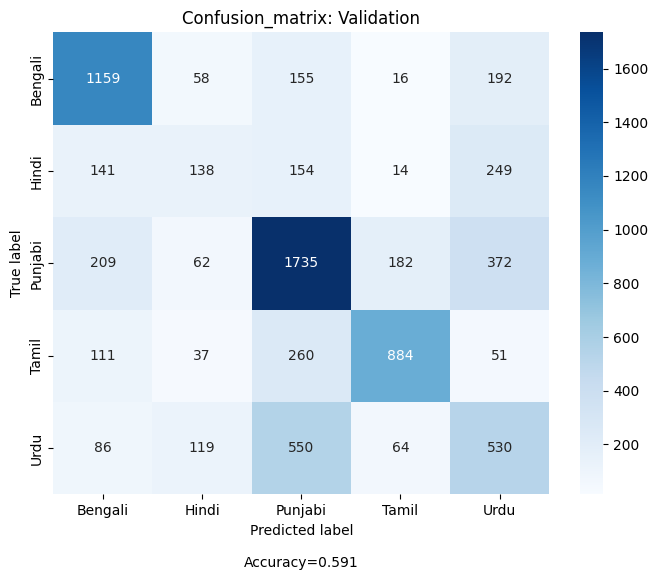

:::::Total vlidation loss 3.9330273743490385, Training accuracy 0.963096496135596, Validation accuracy 0.5905951115834219 after 6 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 7, Batch: 0, Loss: 0.6859211325645447, Accuracy:96.33333333333334%
Epoch: 7, Batch: 50, Loss: 0.5749890208244324, Accuracy:97.0%
Epoch: 7, Batch: 100, Loss: 0.7326920032501221, Accuracy:96.33333333333334%
Epoch: 7, Batch: 150, Loss: 0.633887529373169, Accuracy:97.33333333333334%
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 6.869508743286133, Accuracy:31.25%
#####TEST--in-domain:::::Epoch: 7, Batch: 50, Loss: 8.020862579345703, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 7, Batch: 100, Loss: 14.67349910736084, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 7, Batch: 150, Loss: 3.0069210529327393, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 200, Loss: 3.234229803085327, Accuracy:53.125%


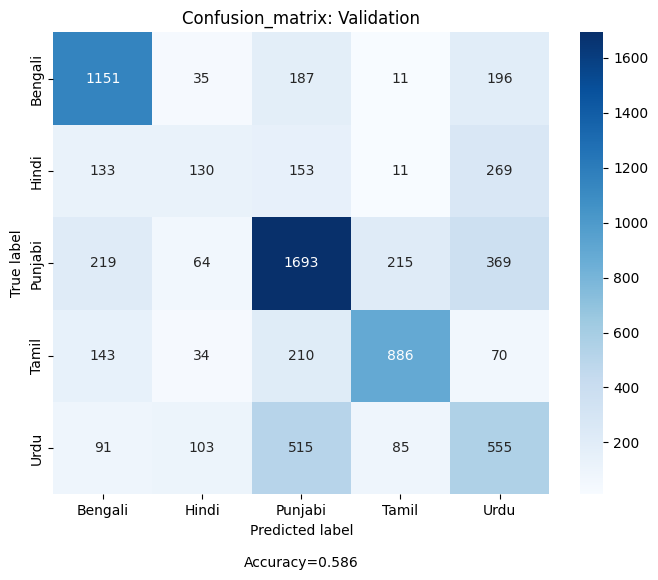

:::::Total vlidation loss 4.139610664846198, Training accuracy 0.9719649406352956, Validation accuracy 0.5864771519659936 after 7 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 8, Batch: 0, Loss: 0.38325873017311096, Accuracy:98.66666666666667%
Epoch: 8, Batch: 50, Loss: 0.3918168246746063, Accuracy:98.66666666666667%
Epoch: 8, Batch: 100, Loss: 0.3510664701461792, Accuracy:99.66666666666667%
Epoch: 8, Batch: 150, Loss: 0.5017011761665344, Accuracy:97.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 6.1252617835998535, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 8, Batch: 50, Loss: 7.045444011688232, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 100, Loss: 13.729093551635742, Accuracy:9.375%
#####TEST--in-domain:::::Epoch: 8, Batch: 150, Loss: 4.708316802978516, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 8, Batch: 200, Loss: 3.619999647140503, Accuracy:46.875%


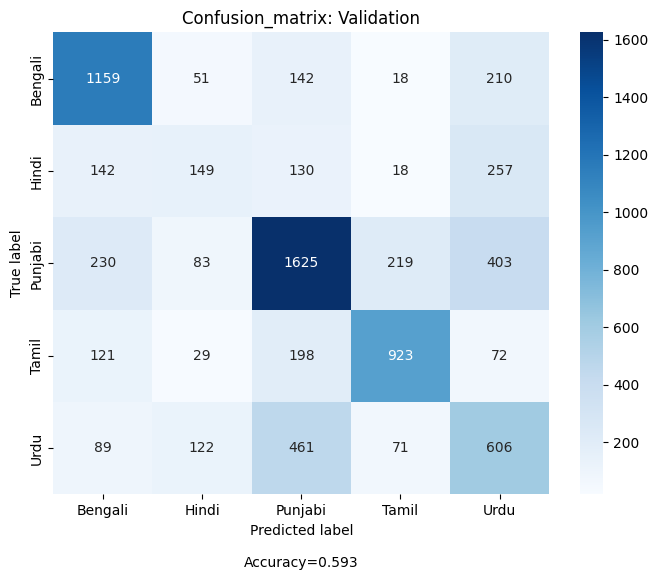

:::::Total vlidation loss 4.155576464423733, Training accuracy 0.9773937547916537, Validation accuracy 0.592720510095643 after 8 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 9, Batch: 0, Loss: 0.5073833465576172, Accuracy:97.0%
Epoch: 9, Batch: 50, Loss: 0.29624590277671814, Accuracy:98.66666666666667%
Epoch: 9, Batch: 100, Loss: 0.5185138583183289, Accuracy:97.0%
Epoch: 9, Batch: 150, Loss: 0.29295116662979126, Accuracy:98.66666666666667%
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 5.881162166595459, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 9, Batch: 50, Loss: 7.80009651184082, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 100, Loss: 13.71453857421875, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 9, Batch: 150, Loss: 2.5973081588745117, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 9, Batch: 200, Loss: 3.37544584274292, Accuracy:50.0%


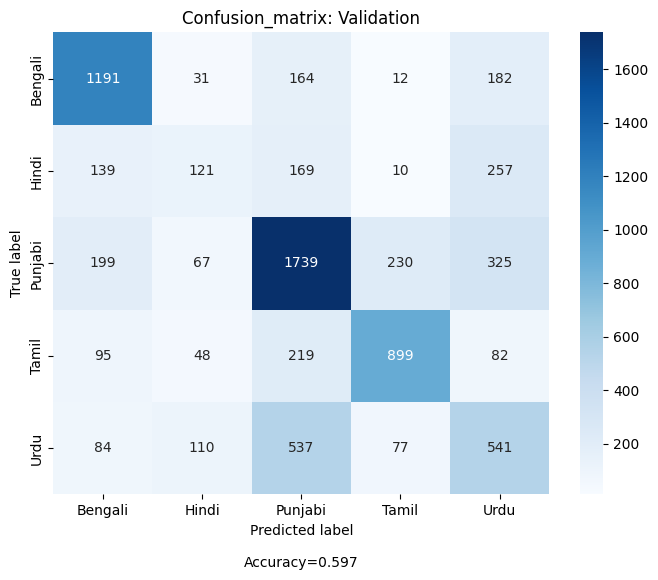

:::::Total vlidation loss 4.294899068754646, Training accuracy 0.9866973332504507, Validation accuracy 0.5965727948990436 after 9 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 10, Batch: 0, Loss: 0.21261902153491974, Accuracy:99.66666666666667%
Epoch: 10, Batch: 50, Loss: 0.36019429564476013, Accuracy:97.66666666666667%
Epoch: 10, Batch: 100, Loss: 0.21412457525730133, Accuracy:99.33333333333333%
Epoch: 10, Batch: 150, Loss: 0.2739722430706024, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 5.536681175231934, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 10, Batch: 50, Loss: 6.852950572967529, Accuracy:28.125%
#####TEST--in-domain:::::Epoch: 10, Batch: 100, Loss: 12.138012886047363, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 10, Batch: 150, Loss: 4.322052001953125, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 200, Loss: 4.536351680755615, Accuracy:40.625%


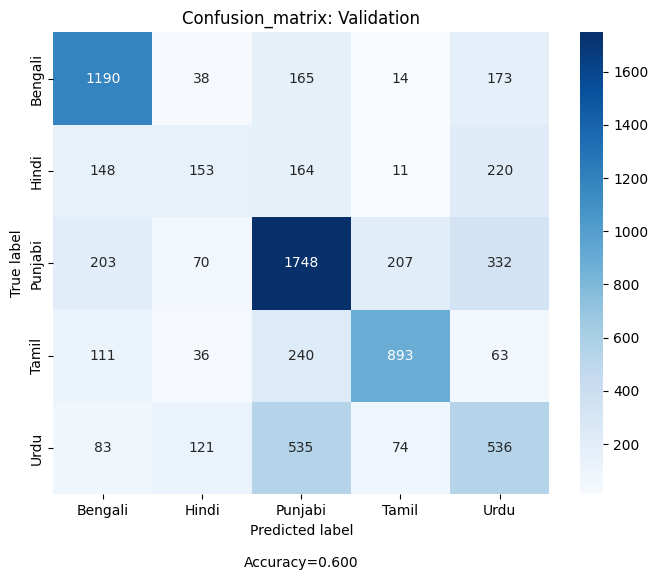

:::::Total vlidation loss 4.244414985563479, Training accuracy 0.9898261536230082, Validation accuracy 0.6004250797024442 after 10 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 11, Batch: 0, Loss: 0.17749275267124176, Accuracy:99.66666666666667%
Epoch: 11, Batch: 50, Loss: 0.2717839777469635, Accuracy:99.0%
Epoch: 11, Batch: 100, Loss: 0.28374505043029785, Accuracy:99.0%
Epoch: 11, Batch: 150, Loss: 0.18481935560703278, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 6.08247184753418, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 11, Batch: 50, Loss: 7.324613094329834, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 11, Batch: 100, Loss: 11.573199272155762, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 150, Loss: 4.390931606292725, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 11, Batch: 200, Loss: 3.820613384246826, Accuracy:43.75%


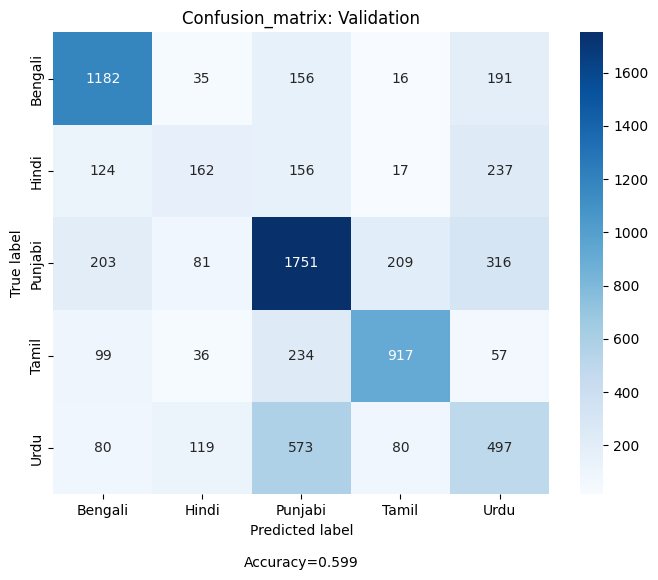

:::::Total vlidation loss 4.417131342427102, Training accuracy 0.9924369573775926, Validation accuracy 0.5989638682252922 after 11 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 12, Batch: 0, Loss: 0.15727035701274872, Accuracy:100.0%
Epoch: 12, Batch: 50, Loss: 0.18195562064647675, Accuracy:100.0%
Epoch: 12, Batch: 100, Loss: 0.207370787858963, Accuracy:99.66666666666667%
Epoch: 12, Batch: 150, Loss: 0.18722088634967804, Accuracy:98.66666666666667%
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 6.195490837097168, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 12, Batch: 50, Loss: 6.409721851348877, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 12, Batch: 100, Loss: 15.16298770904541, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 12, Batch: 150, Loss: 4.485911846160889, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 12, Batch: 200, Loss: 3.5217080116271973, Accuracy:50.0%


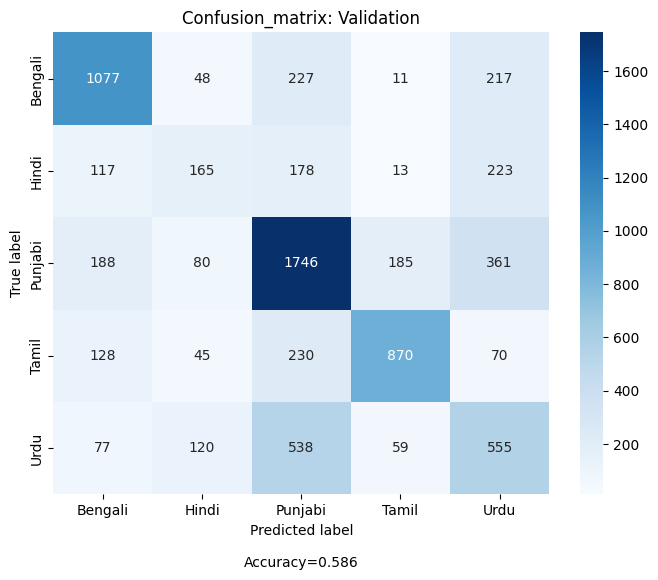

:::::Total vlidation loss 4.560867162120359, Training accuracy 0.9938252419137606, Validation accuracy 0.586211477151966 after 12 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 13, Batch: 0, Loss: 0.13706497848033905, Accuracy:100.0%
Epoch: 13, Batch: 50, Loss: 0.15813478827476501, Accuracy:99.0%
Epoch: 13, Batch: 100, Loss: 0.10144057124853134, Accuracy:100.0%
Epoch: 13, Batch: 150, Loss: 0.1984749734401703, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 6.01358699798584, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 13, Batch: 50, Loss: 7.910747051239014, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 13, Batch: 100, Loss: 12.877606391906738, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 13, Batch: 150, Loss: 4.018155097961426, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 13, Batch: 200, Loss: 4.909329414367676, Accuracy:37.5%


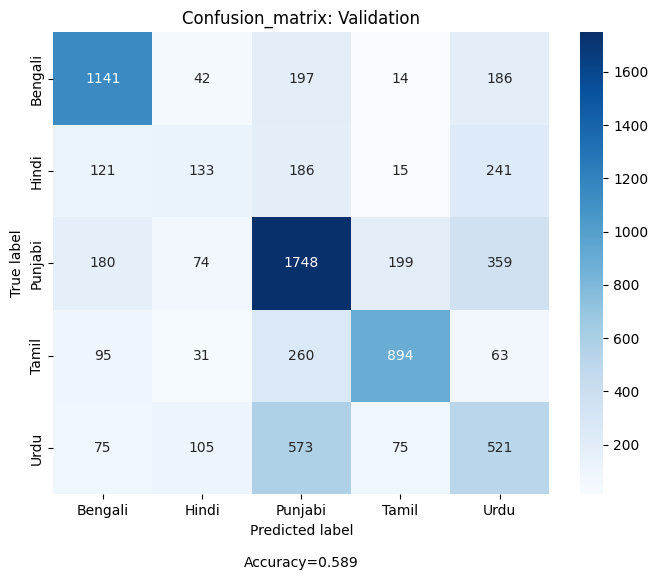

:::::Total vlidation loss 4.566213973666128, Training accuracy 0.9961459563622801, Validation accuracy 0.5893995749202976 after 13 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 14, Batch: 0, Loss: 0.08113951236009598, Accuracy:100.0%
Epoch: 14, Batch: 50, Loss: 0.19300562143325806, Accuracy:98.66666666666667%
Epoch: 14, Batch: 100, Loss: 0.09350280463695526, Accuracy:99.66666666666667%
Epoch: 14, Batch: 150, Loss: 0.220706969499588, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 7.341080665588379, Accuracy:37.5%
#####TEST--in-domain:::::Epoch: 14, Batch: 50, Loss: 7.739917278289795, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 14, Batch: 100, Loss: 13.005934715270996, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 14, Batch: 150, Loss: 3.133516311645508, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 14, Batch: 200, Loss: 4.032701015472412, Accuracy:43.75%


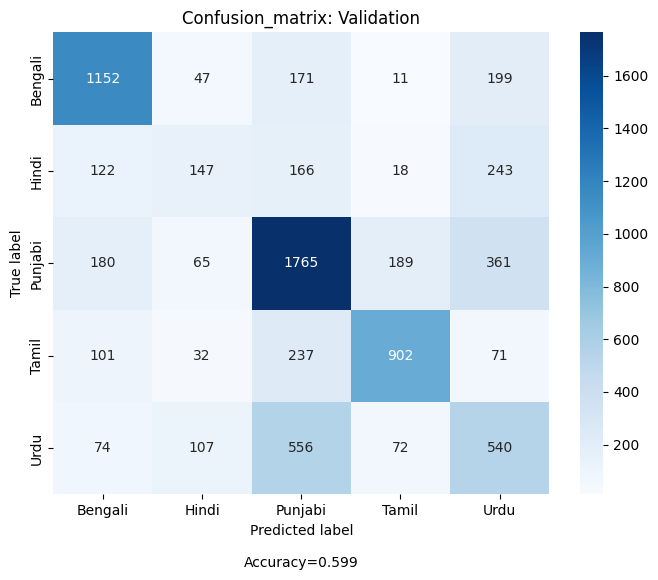

:::::Total vlidation loss 4.590091564836571, Training accuracy 0.9967675763038478, Validation accuracy 0.5985653560042508 after 14 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 15, Batch: 0, Loss: 0.056234557181596756, Accuracy:100.0%
Epoch: 15, Batch: 50, Loss: 0.09194673597812653, Accuracy:100.0%
Epoch: 15, Batch: 100, Loss: 0.10444192588329315, Accuracy:100.0%
Epoch: 15, Batch: 150, Loss: 0.1957746148109436, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 6.888045310974121, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 15, Batch: 50, Loss: 8.111099243164062, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 15, Batch: 100, Loss: 13.767605781555176, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 15, Batch: 150, Loss: 4.579947471618652, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 15, Batch: 200, Loss: 3.817045211791992, Accuracy:50.0%


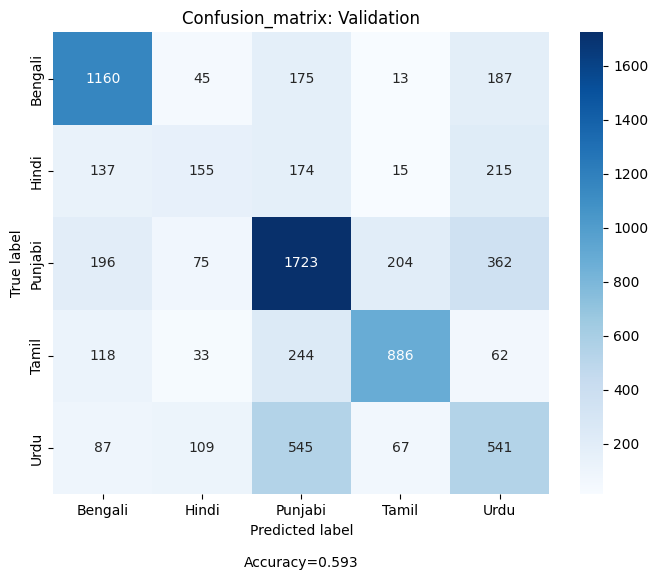

:::::Total vlidation loss 4.658470570514228, Training accuracy 0.9973477549159777, Validation accuracy 0.5931190223166843 after 15 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 16, Batch: 0, Loss: 0.19938239455223083, Accuracy:99.66666666666667%
Epoch: 16, Batch: 50, Loss: 0.09643037617206573, Accuracy:99.66666666666667%
Epoch: 16, Batch: 100, Loss: 0.13727010786533356, Accuracy:99.33333333333333%
Epoch: 16, Batch: 150, Loss: 0.10605441778898239, Accuracy:99.66666666666667%
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 5.899497985839844, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 16, Batch: 50, Loss: 6.97573709487915, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 16, Batch: 100, Loss: 13.693344116210938, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 16, Batch: 150, Loss: 3.5930838584899902, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 16, Batch: 200, Loss: 4.61266565322876, Accuracy:40.625%


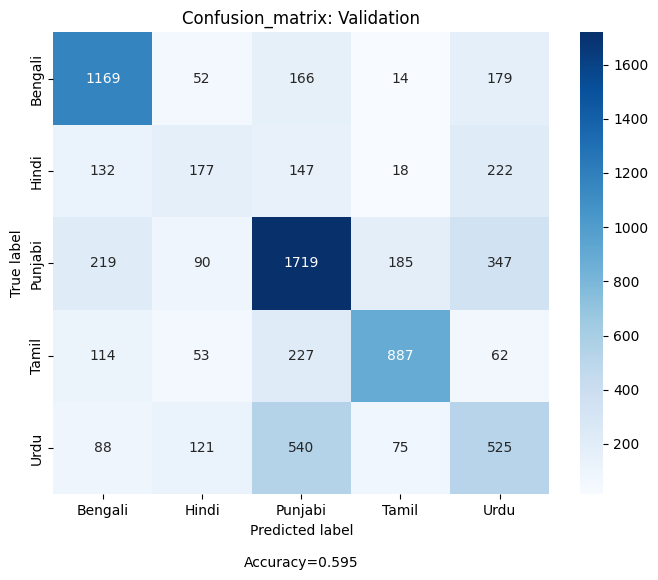

:::::Total vlidation loss 4.61386264760446, Training accuracy 0.997824330204513, Validation accuracy 0.5947130712008502 after 16 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 17, Batch: 0, Loss: 0.04136357083916664, Accuracy:100.0%
Epoch: 17, Batch: 50, Loss: 0.10971391201019287, Accuracy:100.0%
Epoch: 17, Batch: 100, Loss: 0.06423428654670715, Accuracy:100.0%
Epoch: 17, Batch: 150, Loss: 0.09202808886766434, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 5.934325218200684, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 17, Batch: 50, Loss: 8.512822151184082, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 17, Batch: 100, Loss: 14.104636192321777, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 17, Batch: 150, Loss: 4.382016181945801, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 200, Loss: 3.9239606857299805, Accuracy:50.0%


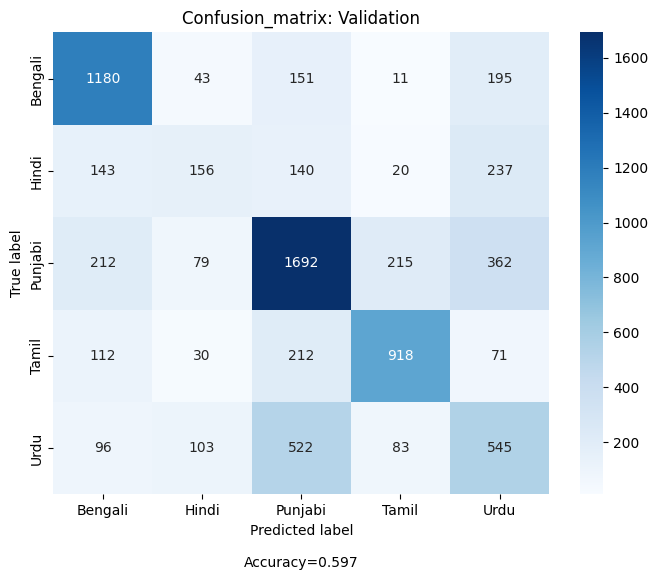

:::::Total vlidation loss 4.643975201817388, Training accuracy 0.9983630674872049, Validation accuracy 0.5965727948990436 after 17 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 18, Batch: 0, Loss: 0.09456747770309448, Accuracy:100.0%
Epoch: 18, Batch: 50, Loss: 0.036335673183202744, Accuracy:100.0%
Epoch: 18, Batch: 100, Loss: 0.04008848965167999, Accuracy:100.0%
Epoch: 18, Batch: 150, Loss: 0.06231343001127243, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 5.931872367858887, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 18, Batch: 50, Loss: 7.622182846069336, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 100, Loss: 13.740806579589844, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 18, Batch: 150, Loss: 4.581894874572754, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 18, Batch: 200, Loss: 4.578466892242432, Accuracy:43.75%


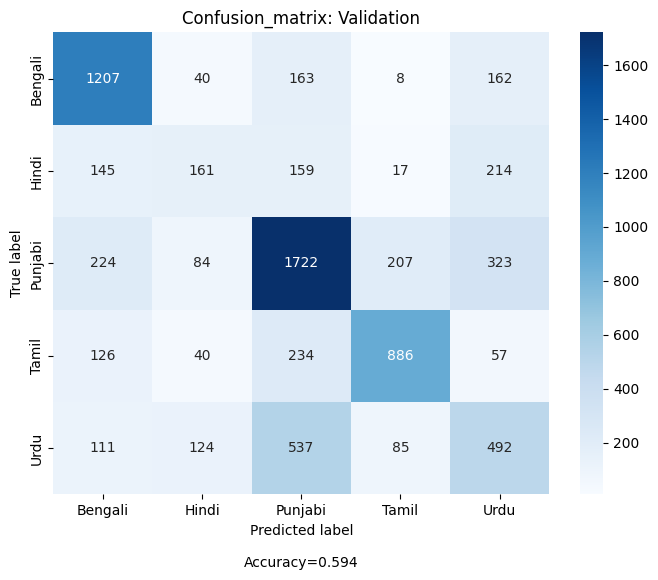

:::::Total vlidation loss 4.724636161059202, Training accuracy 0.9985909947991132, Validation accuracy 0.5935175345377258 after 18 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 19, Batch: 0, Loss: 0.053157925605773926, Accuracy:100.0%
Epoch: 19, Batch: 50, Loss: 0.14723503589630127, Accuracy:99.33333333333333%
Epoch: 19, Batch: 100, Loss: 0.1183076873421669, Accuracy:99.66666666666667%
Epoch: 19, Batch: 150, Loss: 0.07543658465147018, Accuracy:99.66666666666667%
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 6.656482219696045, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 19, Batch: 50, Loss: 8.19056510925293, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 19, Batch: 100, Loss: 14.583101272583008, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 19, Batch: 150, Loss: 4.135457515716553, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 200, Loss: 3.4320569038391113, Accuracy:53.125%


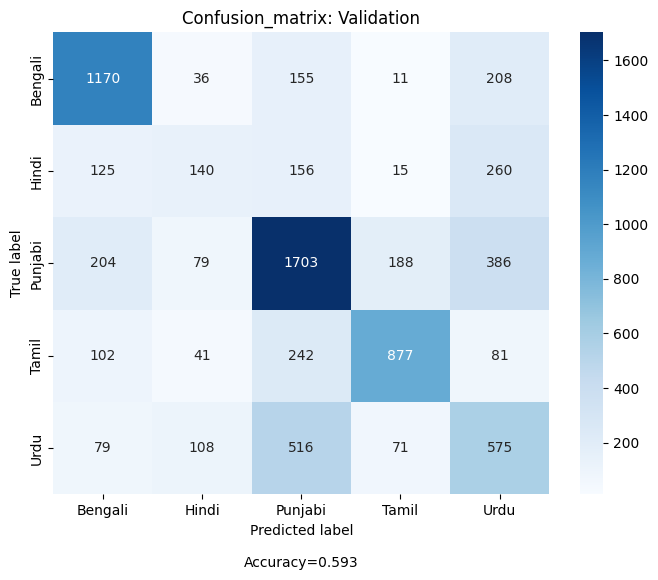

:::::Total vlidation loss 4.760818265676964, Training accuracy 0.9986738774579889, Validation accuracy 0.5931190223166843 after 19 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 20, Batch: 0, Loss: 0.04761836305260658, Accuracy:100.0%
Epoch: 20, Batch: 50, Loss: 0.10781950503587723, Accuracy:99.66666666666667%
Epoch: 20, Batch: 100, Loss: 0.08211078494787216, Accuracy:100.0%
Epoch: 20, Batch: 150, Loss: 0.07479085773229599, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 5.593961715698242, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 20, Batch: 50, Loss: 7.71858549118042, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 20, Batch: 100, Loss: 14.783645629882812, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 20, Batch: 150, Loss: 4.412055492401123, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 200, Loss: 4.065906524658203, Accuracy:50.0%


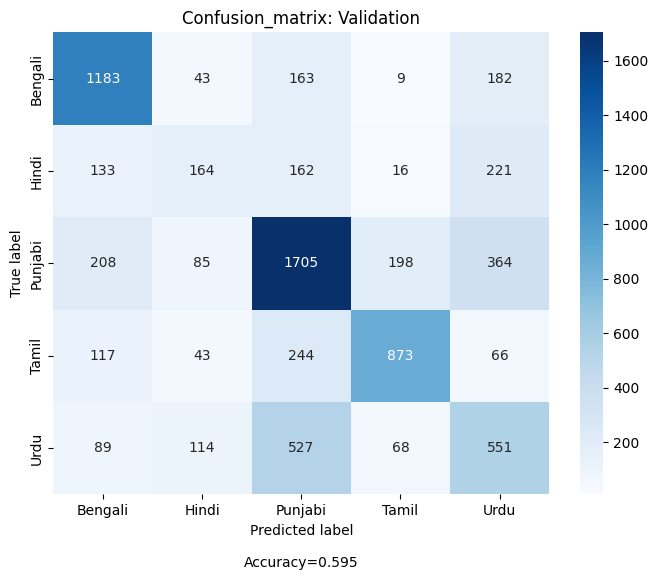

:::::Total vlidation loss 4.748167925599564, Training accuracy 0.9987567601168645, Validation accuracy 0.5945802337938364 after 20 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 21, Batch: 0, Loss: 0.09913825988769531, Accuracy:99.33333333333333%
Epoch: 21, Batch: 50, Loss: 0.13427241146564484, Accuracy:99.66666666666667%
Epoch: 21, Batch: 100, Loss: 0.06093773990869522, Accuracy:100.0%
Epoch: 21, Batch: 150, Loss: 0.07867894321680069, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 6.758060932159424, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 21, Batch: 50, Loss: 8.575469017028809, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 21, Batch: 100, Loss: 13.425141334533691, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 21, Batch: 150, Loss: 4.030825138092041, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 21, Batch: 200, Loss: 4.0445098876953125, Accuracy:50.0%


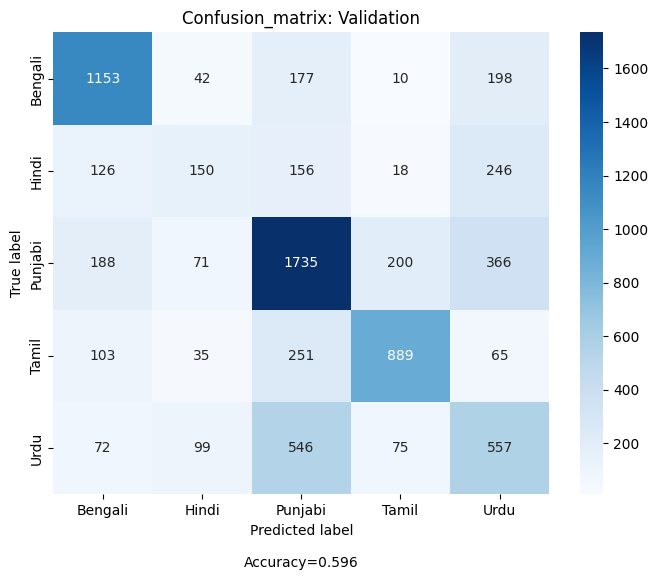

:::::Total vlidation loss 4.752955008859042, Training accuracy 0.9989432460993348, Validation accuracy 0.5956429330499469 after 21 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 22, Batch: 0, Loss: 0.049669165164232254, Accuracy:100.0%
Epoch: 22, Batch: 50, Loss: 0.03789835423231125, Accuracy:100.0%
Epoch: 22, Batch: 100, Loss: 0.08336683362722397, Accuracy:99.66666666666667%
Epoch: 22, Batch: 150, Loss: 0.056760579347610474, Accuracy:99.66666666666667%
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 6.109261989593506, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 22, Batch: 50, Loss: 7.372527599334717, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 22, Batch: 100, Loss: 13.176764488220215, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 22, Batch: 150, Loss: 3.7601945400238037, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 22, Batch: 200, Loss: 4.793927192687988, Accuracy:40.625%


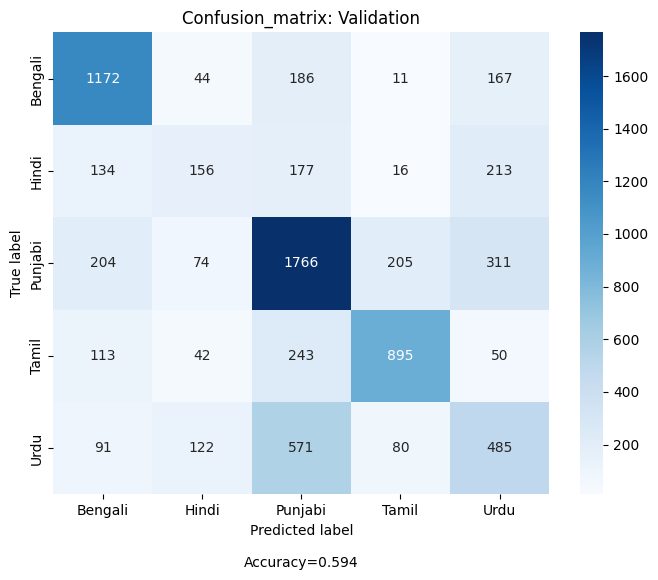

:::::Total vlidation loss 4.785563408260001, Training accuracy 0.9990468494229295, Validation accuracy 0.5943145589798087 after 22 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 23, Batch: 0, Loss: 0.08261367678642273, Accuracy:100.0%
Epoch: 23, Batch: 50, Loss: 0.05606335401535034, Accuracy:100.0%
Epoch: 23, Batch: 100, Loss: 0.03883805871009827, Accuracy:100.0%
Epoch: 23, Batch: 150, Loss: 0.044738903641700745, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 23, Batch: 0, Loss: 6.49564266204834, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 23, Batch: 50, Loss: 7.989617347717285, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 23, Batch: 100, Loss: 12.815461158752441, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 23, Batch: 150, Loss: 3.4889535903930664, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 23, Batch: 200, Loss: 4.643087863922119, Accuracy:37.5%


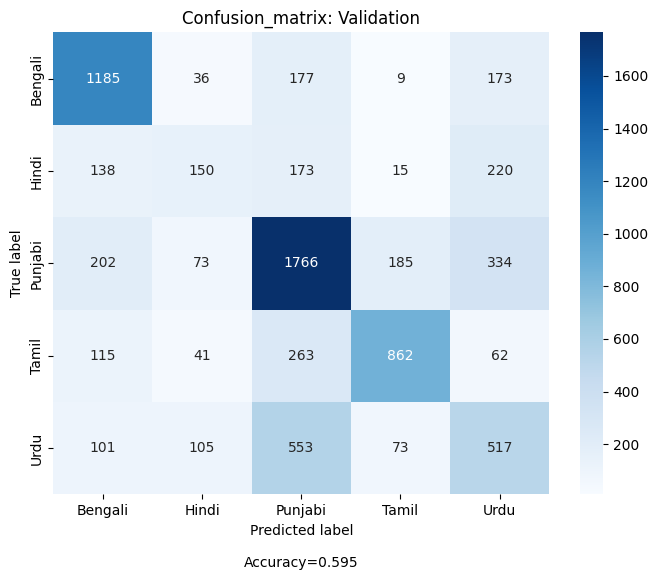

:::::Total vlidation loss 4.790485636817958, Training accuracy 0.9989846874287727, Validation accuracy 0.5951115834218916 after 23 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 24, Batch: 0, Loss: 0.1064271628856659, Accuracy:99.66666666666667%
Epoch: 24, Batch: 50, Loss: 0.040089063346385956, Accuracy:100.0%
Epoch: 24, Batch: 100, Loss: 0.07276308536529541, Accuracy:99.66666666666667%
Epoch: 24, Batch: 150, Loss: 0.03987465798854828, Accuracy:99.66666666666667%
#####TEST--in-domain:::::Epoch: 24, Batch: 0, Loss: 6.213874340057373, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 24, Batch: 50, Loss: 8.381382942199707, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 24, Batch: 100, Loss: 13.56186580657959, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 24, Batch: 150, Loss: 4.078446388244629, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 24, Batch: 200, Loss: 4.459659576416016, Accuracy:40.625%


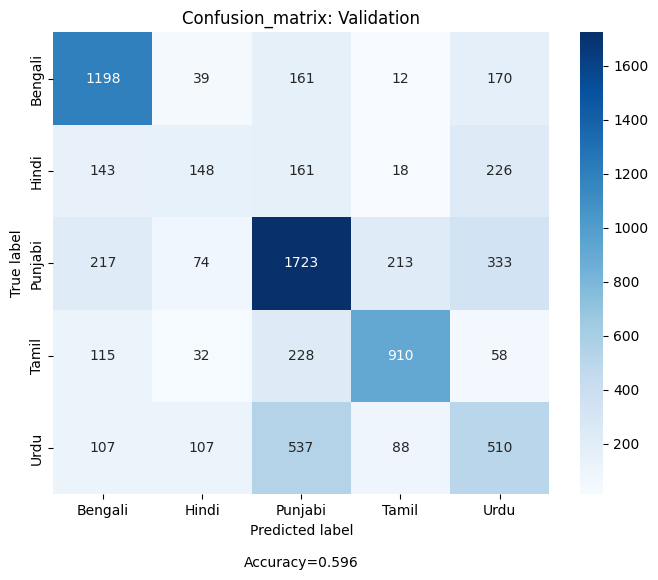

:::::Total vlidation loss 4.7966989928655455, Training accuracy 0.9993162180642755, Validation accuracy 0.596307120085016 after 24 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 25, Batch: 0, Loss: 0.031998783349990845, Accuracy:100.0%
Epoch: 25, Batch: 50, Loss: 0.02264397405087948, Accuracy:100.0%
Epoch: 25, Batch: 100, Loss: 0.03733241185545921, Accuracy:100.0%
Epoch: 25, Batch: 150, Loss: 0.023061439394950867, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 0, Loss: 6.157719612121582, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 25, Batch: 50, Loss: 8.585810661315918, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 25, Batch: 100, Loss: 14.087342262268066, Accuracy:15.625%
#####TEST--in-domain:::::Epoch: 25, Batch: 150, Loss: 4.269680976867676, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 25, Batch: 200, Loss: 4.454366207122803, Accuracy:40.625%


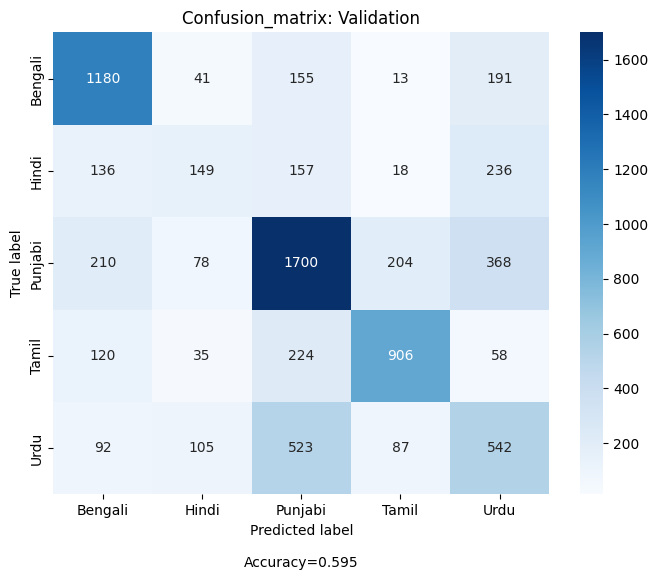

:::::Total vlidation loss 4.8080939491352614, Training accuracy 0.9993576593937133, Validation accuracy 0.5947130712008502 after 25 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 26, Batch: 0, Loss: 0.024840276688337326, Accuracy:100.0%
Epoch: 26, Batch: 50, Loss: 0.03458331152796745, Accuracy:100.0%
Epoch: 26, Batch: 100, Loss: 0.09844088554382324, Accuracy:100.0%
Epoch: 26, Batch: 150, Loss: 0.029931582510471344, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 0, Loss: 6.651906967163086, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 26, Batch: 50, Loss: 7.933806896209717, Accuracy:25.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 100, Loss: 14.912713050842285, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 26, Batch: 150, Loss: 4.335887908935547, Accuracy:50.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 200, Loss: 4.197393417358398, Accuracy:46.875%


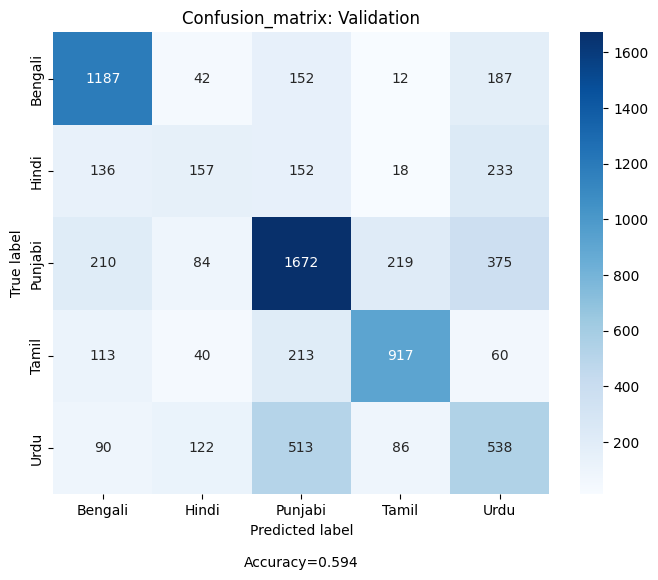

:::::Total vlidation loss 4.800779499445074, Training accuracy 0.9993576593937133, Validation accuracy 0.5939160467587673 after 26 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 27, Batch: 0, Loss: 0.06376615166664124, Accuracy:100.0%
Epoch: 27, Batch: 50, Loss: 0.07221278548240662, Accuracy:99.66666666666667%
Epoch: 27, Batch: 100, Loss: 0.042713116854429245, Accuracy:100.0%
Epoch: 27, Batch: 150, Loss: 0.030857373028993607, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 27, Batch: 0, Loss: 6.3491034507751465, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 27, Batch: 50, Loss: 8.262128829956055, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 27, Batch: 100, Loss: 14.919065475463867, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 27, Batch: 150, Loss: 3.9516842365264893, Accuracy:56.25%
#####TEST--in-domain:::::Epoch: 27, Batch: 200, Loss: 3.9158220291137695, Accuracy:46.875%


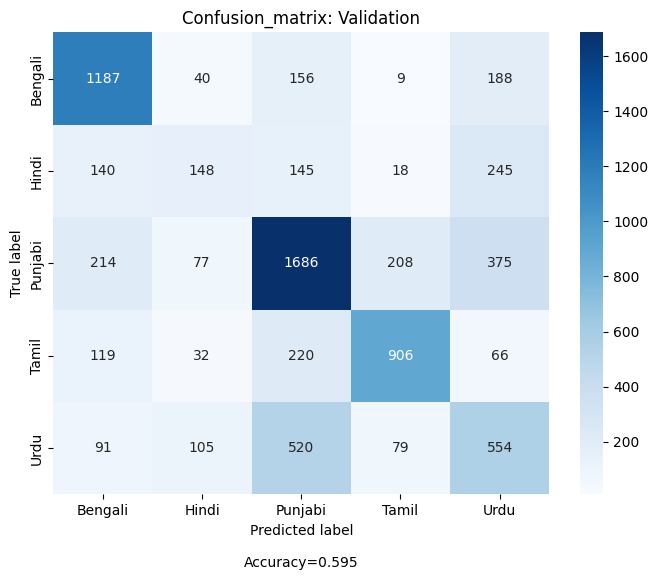

:::::Total vlidation loss 4.836009817162127, Training accuracy 0.9993991007231512, Validation accuracy 0.5952444208289054 after 27 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 28, Batch: 0, Loss: 0.04673215374350548, Accuracy:100.0%
Epoch: 28, Batch: 50, Loss: 0.04933013767004013, Accuracy:100.0%
Epoch: 28, Batch: 100, Loss: 0.04105236008763313, Accuracy:100.0%
Epoch: 28, Batch: 150, Loss: 0.0330289751291275, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 28, Batch: 0, Loss: 5.992632865905762, Accuracy:46.875%
#####TEST--in-domain:::::Epoch: 28, Batch: 50, Loss: 8.253687858581543, Accuracy:21.875%
#####TEST--in-domain:::::Epoch: 28, Batch: 100, Loss: 14.731431007385254, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 28, Batch: 150, Loss: 4.344191074371338, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 28, Batch: 200, Loss: 4.204995632171631, Accuracy:43.75%


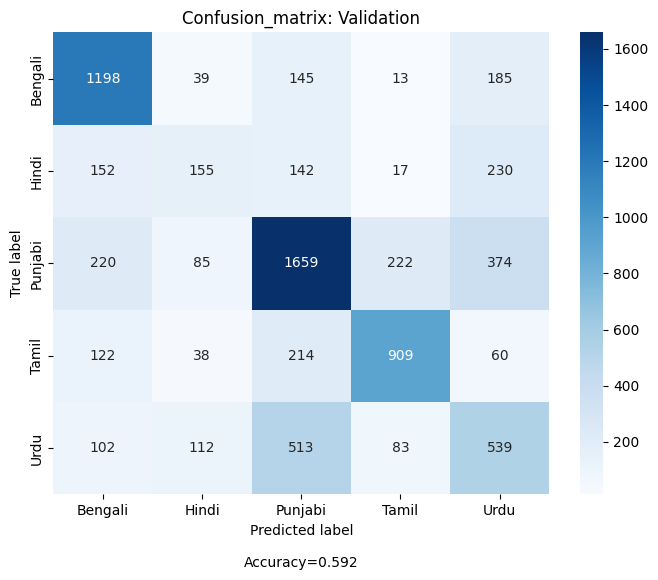

:::::Total vlidation loss 4.816587093527913, Training accuracy 0.999461262717308, Validation accuracy 0.5924548352816154 after 28 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 29, Batch: 0, Loss: 0.05428415909409523, Accuracy:100.0%
Epoch: 29, Batch: 50, Loss: 0.08682987093925476, Accuracy:100.0%
Epoch: 29, Batch: 100, Loss: 0.04721100628376007, Accuracy:100.0%
Epoch: 29, Batch: 150, Loss: 0.0377332903444767, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 29, Batch: 0, Loss: 6.792187213897705, Accuracy:40.625%
#####TEST--in-domain:::::Epoch: 29, Batch: 50, Loss: 8.601898193359375, Accuracy:18.75%
#####TEST--in-domain:::::Epoch: 29, Batch: 100, Loss: 14.508987426757812, Accuracy:12.5%
#####TEST--in-domain:::::Epoch: 29, Batch: 150, Loss: 4.016658306121826, Accuracy:53.125%
#####TEST--in-domain:::::Epoch: 29, Batch: 200, Loss: 3.626983404159546, Accuracy:53.125%


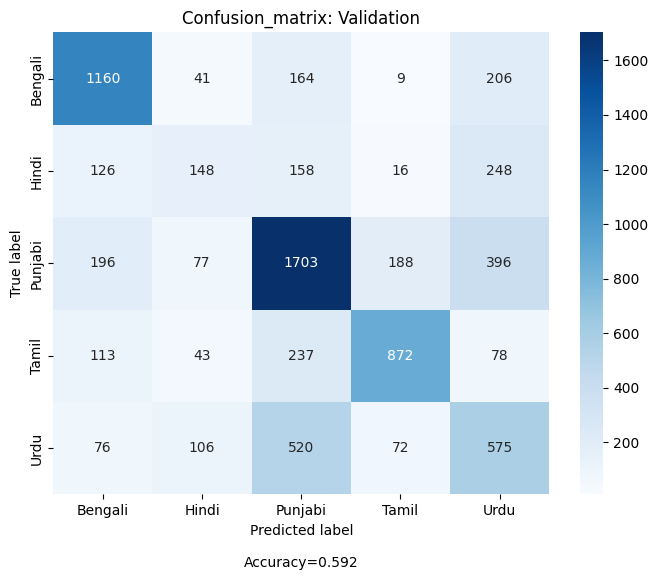

:::::Total vlidation loss 4.833408563287777, Training accuracy 0.9995234247114647, Validation accuracy 0.5921891604675876 after 29 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 30, Batch: 0, Loss: 0.033636290580034256, Accuracy:100.0%
Epoch: 30, Batch: 50, Loss: 0.029714936390519142, Accuracy:100.0%
Epoch: 30, Batch: 100, Loss: 0.03286921977996826, Accuracy:100.0%


: 

In [14]:
#For LR scheduler
import warnings
warnings.filterwarnings('ignore')
dest_path="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/"
os.makedirs(dest_path,exist_ok=True)
#Languages=["Assamese","Bengali","Bodo","Dogri","English","Gujarati","Hindi","Kannada","Kashmiri","Konkani","Maithili","Manipuri","Malayalam","Marathi","Nepali","Odia","Punjabi","Sanskrit","Santali","Sindhi","Tamil","Telugu","Urdu"]
Languages=["Bengali","Hindi","Punjabi","Tamil","Urdu"]
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix
def train(dataloader_train,epoch):
    train_loss_list=[]
    train_acc_list=[]
    full_preds=[]
    full_gts=[]

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        #features=torch.transpose(features,0,2,1)
        #print(features.shape)
        #print(labels.shape)
        #features=minmax(features)
        features, labels = features.to(device).float(),labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss=model.get_loss(pred_logits,labels)
        posterior=model.get_posterior()
        #print(posterior.shape)
        #loss = loss_fun(pred_logits,labels)

        #print(pred_logits.shape)
        #LOSS=[]
        #for ii in range(features.shape[1]):
        #    loss = loss_fun(features[:,ii,:],labels)
        #    LOSS.append(loss)
        #loss=torch.mean(torch.tensor(LOSS))
        #loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
        if i_batch%50==0:
            #print(final_pred)
            acc = accuracy_score(predictions,labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
        train_loss_list.append(loss.item())
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)
    mean_acc = accuracy_score(full_gts,full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    return mean_acc
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss,mean_acc,epoch))
def validation(dataloader_val,epoch,train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list=[]
        full_preds=[]
        full_gts=[]
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            #features=torch.transpose(features,0,2,1)
            features, labels = features.to(device).float(),labels.to(device).long()
            pred_logits = model(features)
            #print(features.shape)
            #print(labels.shape)
            loss=model.get_loss(pred_logits,labels)
            posterior=model.get_posterior()
            #loss = loss_fun(pred_logits,labels)
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
            if i_batch%50==0:
                #print(final_pred)
                acc = accuracy_score(predictions,labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)

        mean_acc2 = accuracy_score(full_gts,full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm=confusion_matrix(full_gts,full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8,6), categories=Languages, cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(':::::Total vlidation loss {}, Training accuracy {}, Validation accuracy {} after {} epochs'.format(mean_loss2,train_accuracy, mean_acc2,epoch))
        print("#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############")
        model_save_path = os.path.join(dest_path,'IIITH_merged_original_Bhagya_ecapa_cms_'+str("{:.3f}".format(train_accuracy*100))+"_"+str("{:.3f}".format(mean_acc2*100))+"_"+str("{:.4f}".format(mean_loss2)))
        state_dict = {'model': model.state_dict(),'optimizer': optimizer.state_dict(),'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range(50):
        mean_acc=train(trainloader,epoch)
        val_loss=validation(testloader1,epoch,mean_acc)
        scheduler.step(val_loss)
        #testing(testloader2,epoch,mean_acc)
        #testing(testloader3,epoch,mean_acc)